# Neural Network - Hourly Demand Prediction

In this section we predict the hourly demand of taxi trips in Chicago.
The prediciton we perform by building a model are based on data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

We split the prediction into spatial units:
- Community Areas
- Hexagons with low resolution
- Hexagons with medium resolution
- Hexagons with high resolution

For each of the units we perform a seperate prediction based on data we have aggregeated in our preparation.

Our procedure in this part is structured in the following way:

- Explore different Neural Network architectures to find out which performs best. We do this based on Community areas.
- Hyperparameter tuning to find the best Neural Network Architecture
- Make predictions for all spatial units with the Architecture winner of the Hyperparametertuning
- Evaluation

<hr style="border: 1px solid #8888;">

In [1]:
pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.9 MB/s eta 0:00:00


In [2]:
# Import all necessary packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats import loguniform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, max_error
import os.path

# Import keras libraries
import tensorflow
from tensorflow import keras
from keras import layers
import keras_tuner
from keras_tuner.tuners import Hyperband
import IPython

In [3]:
print("GPU Available:", tensorflow.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True


<hr style="border: 1px solid #8888;">

## Preprocessing

In [4]:
# import datasets local
#df_h_comar = pd.read_csv("../data/datasets/df_h_comar.csv")
#df_h_hexlow = pd.read_csv("../data/datasets/df_h_hexlow.csv")
#df_h_hexmed = pd.read_csv("../data/datasets/df_h_hexmed.csv")
#df_h_hexhig = pd.read_csv("../data/datasets/df_h_hexhig.csv")

# Import datasets in Google Colab
df_h_comar = pd.read_csv("/content/df_h_comar.csv")
df_h_hexlow = pd.read_csv("/content/df_h_hexlow.csv")
df_h_hexmed = pd.read_csv("/content/df_h_hexmed.csv")
df_h_hexhig = pd.read_csv("/content/df_h_hexhig.csv")

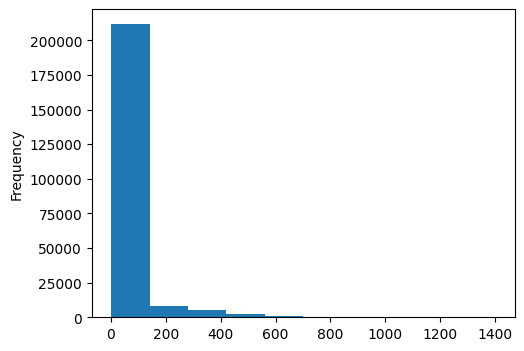

In [5]:
plt.figure(figsize=(12,4))

plt.subplot(121)
df_h_comar['numOfTaxis_area'].plot.hist()

#plt.subplot(122)
#df_h_comar['numOfTaxis_area'] = np.log(df_h_comar['numOfTaxis_area'])
#df_h_comar['numOfTaxis_area'].plot.hist()
plt.show()

Even if the distribution does not look good, we do not use the log transformation at this point, because only simple neural networks benefit from it, but more complex ones even become worse (**we have tested this!**).

In [6]:
#df_h_hexlow['numOfTaxis_area'] = np.log(df_h_hexlow['numOfTaxis_area'])
#df_h_hexmed['numOfTaxis_area'] = np.log(df_h_hexmed['numOfTaxis_area'])
#df_h_hexhig['numOfTaxis_area'] = np.log(df_h_hexhig['numOfTaxis_area'])

In [7]:
df_h_comar.drop(columns = ['date_start'],inplace = True)
df_h_hexlow.drop(columns = ['date_start'],inplace = True)
df_h_hexmed.drop(columns = ['date_start'],inplace = True)
df_h_hexhig.drop(columns = ['date_start'],inplace = True)

In [8]:
def dayandseas_to_int(df):

    df['dayOfWeek'] = df['dayOfWeek'].replace(['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[0,1,2,3,4,5,6])
    df['season'] = df['season'].replace(['summer', 'winter','spring','autumn'],[0,1,2,3])

    return df

In [9]:
df_h_comar = dayandseas_to_int(df_h_comar)
df_h_hexlow = dayandseas_to_int(df_h_hexlow)
df_h_hexmed = dayandseas_to_int(df_h_hexmed)
df_h_hexhig = dayandseas_to_int(df_h_hexhig)

<ipython-input-10-c6fec9bde0d5>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_h_comar.drop(columns = ['numOfTaxis_area']).corr()


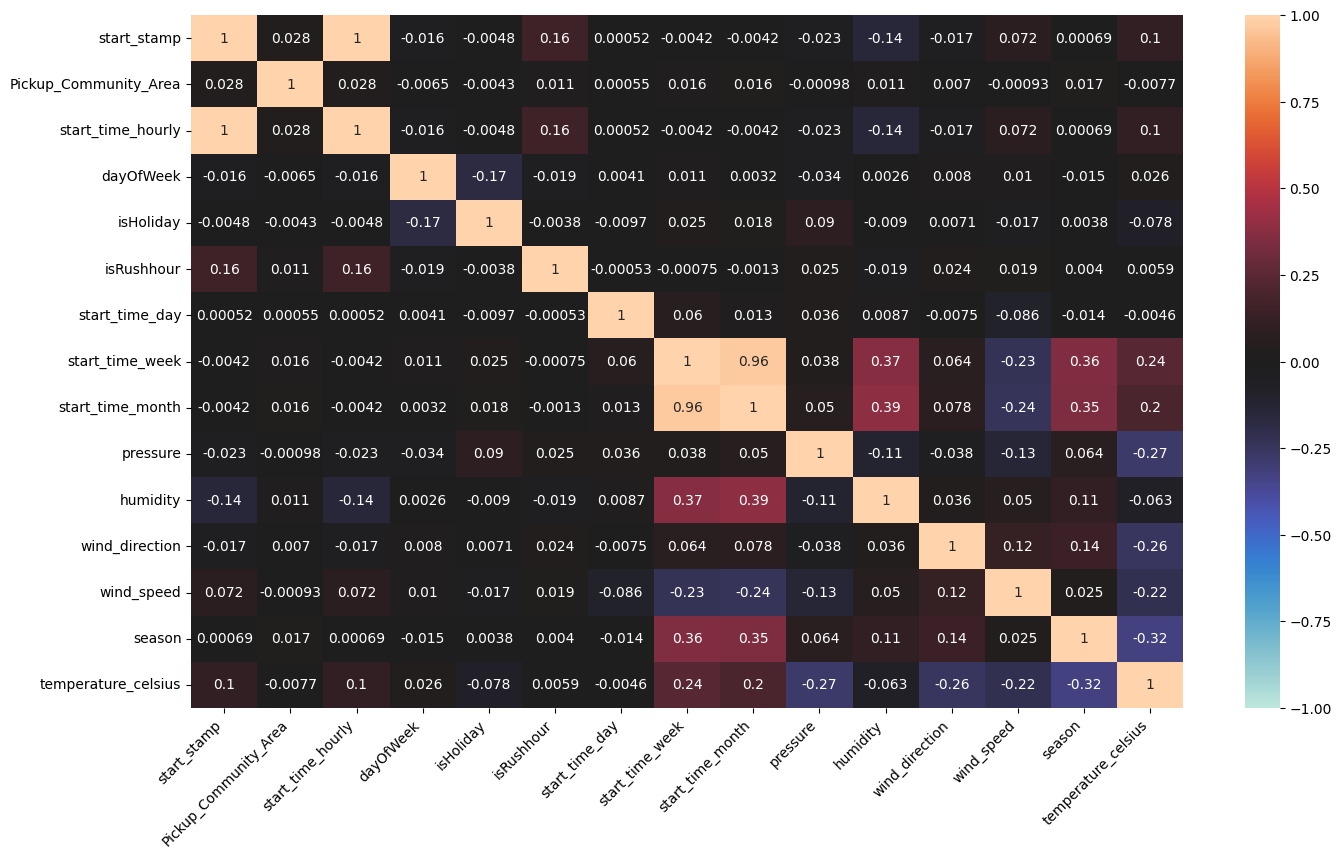

In [10]:
# correlation matrix of df_h_comar

import seaborn as sns
corr = df_h_comar.drop(columns = ['numOfTaxis_area']).corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

Because we are looking at the hourly demand, `start_time_hourly` and `start_stamp` is the same. So there are perfectly correlated and we are dropping `start_time_hourly`. We also have a very high correlation between `start_time_month` and `start_time_week`, which leads to dropping `start_time_month`:

In [11]:
df_h_comar.drop(columns = ['start_time_hourly'],inplace = True)

In [12]:
df_h_comar.drop(columns = ['start_time_month'],inplace = True)

Doing the same for the dataframes of:

- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

In [13]:
df_h_hexlow.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)
df_h_hexmed.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)
df_h_hexhig.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)

<hr style="border: 1px solid #8888;">

## General functions

In [14]:
# Calculate Metrics
def evaluate_performance(y_test,pred_ann,df):
    print("MODEL SCORES")
    print("MAE:", round(mean_absolute_error(y_test,pred_ann), 4))
    print("MSE:", round(mean_squared_error(y_test, pred_ann), 4))
    print("RMSE:", round(mean_squared_error(y_test,pred_ann)**0.5, 4))
    print("MAPE:", round(mean_absolute_percentage_error(y_test,pred_ann)*100, 2), "%")
    print("Rough Accuracy Approximation:", round((1-(mean_absolute_error(y_test,pred_ann)/df["numOfTaxis_area"].mean()))*100,2), "%")
    print("R2:", round(r2_score(y_test,pred_ann), 4))
    print("Max Residual Error:", round(max_error(y_test,pred_ann), 4))

<hr style="border: 1px solid #8888;">

## 1. Hourly Demand - Community Area

- Before running you have to install tensorflow: `pip install tensorflow`

### **Feature engineering**

Here we will shortly create dummy variables and split the data and normalize it

In [15]:
df_h_comar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229192 entries, 0 to 229191
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   start_stamp            229192 non-null  int64  
 1   Pickup_Community_Area  229192 non-null  float64
 2   numOfTaxis_area        229192 non-null  int64  
 3   dayOfWeek              229192 non-null  int64  
 4   isHoliday              229192 non-null  bool   
 5   isRushhour             229192 non-null  bool   
 6   start_time_day         229192 non-null  int64  
 7   start_time_week        229192 non-null  int64  
 8   pressure               229192 non-null  float64
 9   humidity               229192 non-null  float64
 10  wind_direction         229192 non-null  float64
 11  wind_speed             229192 non-null  float64
 12  description            229192 non-null  object 
 13  season                 229192 non-null  int64  
 14  temperature_celsius    229192 non-nu

In [16]:
# Prepare variables for dummy creation
df_h_comar['start_stamp'] = df_h_comar['start_stamp'].astype(str)
df_h_comar['Pickup_Community_Area'] = df_h_comar['Pickup_Community_Area'].astype(str)
df_h_comar['dayOfWeek'] = df_h_comar['dayOfWeek'].astype(str)
df_h_comar['start_time_day'] = df_h_comar['start_time_day'].astype(str)
df_h_comar['start_time_week'] = df_h_comar['start_time_week'].astype(str)
df_h_comar['season'] = df_h_comar['season'].astype(str)
df_h_comar['description'] = df_h_comar['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_h_comar = pd.get_dummies(df_h_comar)
df_h_comar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229192 entries, 0 to 229191
Columns: 227 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(219)
memory usage: 58.8 MB


In [17]:
df_h_comar

,numOfTaxis_area,isHoliday,isRushhour,pressure,humidity,wind_direction,wind_speed,temperature_celsius,start_stamp_0,start_stamp_1,...,description_snow,description_thunderstorm,description_thunderstorm with heavy rain,description_thunderstorm with light rain,description_thunderstorm with rain,description_very heavy rain,season_0,season_1,season_2,season_3
0,4,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
2,43,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
3,13,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
4,17,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229187,2,False,False,1023.0,89.0,217.0,1.0,-11.00,0,0,...,0,0,0,0,0,0,0,1,0,0
229188,3,False,False,1023.0,89.0,217.0,1.0,-11.00,0,0,...,0,0,0,0,0,0,0,1,0,0
229189,1,False,False,1023.0,89.0,217.0,1.0,-11.00,0,0,...,0,0,0,0,0,0,0,1,0,0
229190,5,False,False,1023.0,89.0,217.0,1.0,-11.00,0,0,...,0,0,0,0,0,0,0,1,0,0


In [18]:
# Set output frame and input frame
x = df_h_comar.drop('numOfTaxis_area', axis=1)
y = df_h_comar['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

**We now have the following datasets:**
- x_train, y_train &rarr; 50% input features for training the model
- x_val, y_val &rarr; 20% to select hyperparameters
- x_test, y_test &rarr; 30% to control the accurancy of the model

<hr style="border: 0.5px solid #8888;">

### Exploration of the model: Checking for the best Neural Network Architecture
- Exploration: We will start with some very simple Neural Network designs and gradually increase its complexity by adding more layers and nodes
- Later we will just use the Hyperband tuning algorithm, which is similar to Gridsearch, to do this work for us and decide for the best hyperparameters

#### Exploration: Very Simple Neural Network (1 Hidden Layer with 1 Node)

In [23]:
# Input Layer
inputs = keras.Input(shape=(226,)) # shapesize dependent of input feature count

# Just 1 Hidden Layer
x = layers.Dense(1, activation='relu')(inputs)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

Define a callback that stops earlier if there is no further improvement, restores the model weights from the epoch with the best value of val_loss, and prevents overfitting by monitoring val_loss:

In [24]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True
    )

In [25]:
model_ann.fit(x_train, y_train, epochs=50, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/50
3582/3582 [==============================] - 26s 6ms/step - loss: 7957.4009 - val_loss: 5109.2153
Epoch 2/50
3582/3582 [==============================] - 25s 7ms/step - loss: 4050.6541 - val_loss: 3343.7939
Epoch 3/50
3582/3582 [==============================] - 18s 5ms/step - loss: 3017.2417 - val_loss: 2784.6167
Epoch 4/50
3582/3582 [==============================] - 15s 4ms/step - loss: 2710.8018 - val_loss: 2613.1970
Epoch 5/50
3582/3582 [==============================] - 17s 5ms/step - loss: 2610.2092 - val_loss: 2532.3704
Epoch 6/50
3582/3582 [==============================] - 15s 4ms/step - loss: 2540.0486 - val_loss: 2470.6907
Epoch 7/50
3582/3582 [==============================] - 15s 4ms/step - loss: 2486.7786 - val_loss: 2417.5801
Epoch 8/50
3582/3582 [==============================] - 18s 5ms/step - loss: 2443.2559 - val_loss: 2375.0073
Epoch 9/50
3582/3582 [==============================] - 16s 5ms/step - loss: 2407.0325 - val_loss: 2337.7275
Epoch 10/50
3582/35

In [26]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_h_comar)

2149/2149 [==============================] - 5s 2ms/step
MODEL SCORES
MAE: 20.5419
MSE: 2219.392
RMSE: 47.1104
MAPE: 309.26 %
Rough Accuracy Approximation: 47.54 %
R2: 0.7715
Max Residual Error: 871.8765


#### Exploration: Simple Neural Network (1 Hidden Layer with 8 Nodes)

In [27]:
# Input Layer
inputs = keras.Input(shape=(226,)) # shapesize dependent of input feature count

# Just 1 Hidden Layer
x = layers.Dense(8, activation='relu')(inputs)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=50, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/50
3582/3582 [==============================] - 16s 4ms/step - loss: 5144.2949 - val_loss: 2642.0793
Epoch 2/50
3582/3582 [==============================] - 14s 4ms/step - loss: 2410.5005 - val_loss: 2200.7324
Epoch 3/50
3582/3582 [==============================] - 15s 4ms/step - loss: 2144.6646 - val_loss: 2012.1266
Epoch 4/50
3582/3582 [==============================] - 14s 4ms/step - loss: 1991.2294 - val_loss: 1889.1490
Epoch 5/50
3582/3582 [==============================] - 14s 4ms/step - loss: 1874.9325 - val_loss: 1792.3616
Epoch 6/50
3582/3582 [==============================] - 17s 5ms/step - loss: 1782.4569 - val_loss: 1711.1051
Epoch 7/50
3582/3582 [==============================] - 14s 4ms/step - loss: 1708.1112 - val_loss: 1647.0986
Epoch 8/50
3582/3582 [==============================] - 14s 4ms/step - loss: 1641.6823 - val_loss: 1589.9860
Epoch 9/50
3582/3582 [==============================] - 14s 4ms/step - loss: 1574.5625 - val_loss: 1523.5959
Epoch 10/50
3582/35

In [28]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_h_comar)

2149/2149 [==============================] - 4s 2ms/step
MODEL SCORES
MAE: 12.2533
MSE: 656.5927
RMSE: 25.6241
MAPE: 92.73 %
Rough Accuracy Approximation: 68.71 %
R2: 0.9324
Max Residual Error: 813.2944


#### Exploration: Neural Network (1 Hidden Layer with 512 Nodes)

In [29]:
# Input Layer
inputs = keras.Input(shape=(226,)) # shapesize dependent of input feature count

# Just 1 Hidden Layer
x = layers.Dense(512, activation='relu')(inputs)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=50, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/50
3582/3582 [==============================] - 15s 4ms/step - loss: 2389.5869 - val_loss: 1229.1654
Epoch 2/50
3582/3582 [==============================] - 14s 4ms/step - loss: 850.6609 - val_loss: 632.5278
Epoch 3/50
3582/3582 [==============================] - 14s 4ms/step - loss: 535.4970 - val_loss: 451.9849
Epoch 4/50
3582/3582 [==============================] - 14s 4ms/step - loss: 406.9639 - val_loss: 394.1591
Epoch 5/50
3582/3582 [==============================] - 14s 4ms/step - loss: 337.5965 - val_loss: 335.6650
Epoch 6/50
3582/3582 [==============================] - 14s 4ms/step - loss: 292.1075 - val_loss: 359.9326
Epoch 7/50
3582/3582 [==============================] - 14s 4ms/step - loss: 262.7408 - val_loss: 290.9644
Epoch 8/50
3582/3582 [==============================] - 14s 4ms/step - loss: 235.9970 - val_loss: 264.2337
Epoch 9/50
3582/3582 [==============================] - 14s 4ms/step - loss: 216.3786 - val_loss: 274.9550
Epoch 10/50
3582/3582 [============

In [30]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_h_comar)

2149/2149 [==============================] - 4s 2ms/step
MODEL SCORES
MAE: 8.078
MSE: 208.5234
RMSE: 14.4403
MAPE: 78.28 %
Rough Accuracy Approximation: 79.37 %
R2: 0.9785
Max Residual Error: 407.6956


#### Exploration: Neural Network (3 Hidden Layer with 256 Nodes)

In [31]:
# Input Layer
inputs = keras.Input(shape=(226,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=50, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/50
3582/3582 [==============================] - 19s 5ms/step - loss: 1332.3284 - val_loss: 492.1381
Epoch 2/50
3582/3582 [==============================] - 16s 4ms/step - loss: 381.2640 - val_loss: 296.7582
Epoch 3/50
3582/3582 [==============================] - 16s 5ms/step - loss: 289.8307 - val_loss: 284.0902
Epoch 4/50
3582/3582 [==============================] - 16s 5ms/step - loss: 236.2858 - val_loss: 268.1658
Epoch 5/50
3582/3582 [==============================] - 17s 5ms/step - loss: 199.2730 - val_loss: 259.3975
Epoch 6/50
3582/3582 [==============================] - 16s 5ms/step - loss: 171.2715 - val_loss: 187.6590
Epoch 7/50
3582/3582 [==============================] - 16s 5ms/step - loss: 160.9632 - val_loss: 221.2327
Epoch 8/50
3582/3582 [==============================] - 19s 5ms/step - loss: 139.9570 - val_loss: 278.1389
Epoch 9/50
3582/3582 [==============================] - 16s 5ms/step - loss: 125.6803 - val_loss: 173.6002
Epoch 10/50
3582/3582 [=============

In [32]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_h_comar)

2149/2149 [==============================] - 4s 2ms/step
MODEL SCORES
MAE: 5.2681
MSE: 146.8715
RMSE: 12.1191
MAPE: 39.56 %
Rough Accuracy Approximation: 86.55 %
R2: 0.9849
Max Residual Error: 340.5676


#### Exploration: Complex Neural Network (8 Hidden Layer with mixed number of Nodes)

In [33]:
# Input Layer
inputs = keras.Input(shape=(226,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=50, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/50
3582/3582 [==============================] - 25s 6ms/step - loss: 1382.4194 - val_loss: 602.0242
Epoch 2/50
3582/3582 [==============================] - 24s 7ms/step - loss: 484.4329 - val_loss: 363.8171
Epoch 3/50
3582/3582 [==============================] - 22s 6ms/step - loss: 363.0553 - val_loss: 349.4863
Epoch 4/50
3582/3582 [==============================] - 21s 6ms/step - loss: 276.2436 - val_loss: 319.9881
Epoch 5/50
3582/3582 [==============================] - 24s 7ms/step - loss: 250.1220 - val_loss: 221.2354
Epoch 6/50
3582/3582 [==============================] - 24s 7ms/step - loss: 200.0533 - val_loss: 293.1664
Epoch 7/50
3582/3582 [==============================] - 25s 7ms/step - loss: 176.7466 - val_loss: 308.8260
Epoch 8/50
3582/3582 [==============================] - 22s 6ms/step - loss: 173.1952 - val_loss: 172.1722
Epoch 9/50
3582/3582 [==============================] - 21s 6ms/step - loss: 136.6631 - val_loss: 200.5125
Epoch 10/50
3582/3582 [=============

In [34]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_h_comar)

2149/2149 [==============================] - 4s 2ms/step
MODEL SCORES
MAE: 5.1515
MSE: 138.6049
RMSE: 11.7731
MAPE: 39.75 %
Rough Accuracy Approximation: 86.84 %
R2: 0.9857
Max Residual Error: 318.1094


<hr style="border: 0.5px solid #8888;">

### Hyperparameter Tuning for the best model (in terms of best metric)

**Building the model with the functional API of Keras:**

In [35]:
def build_model(hp):
    # Input Layer
    inputs = keras.Input(shape=(226,)) # shapesize dependent of input feature count

    # Hidden Layers
    ## Initialize x
    x = inputs

    ## Possible Hidden Layers
    for i in range(hp.Int('total_hidden_layers', 0, 10)):
        layer_name = 'hidden_layer_' + str(i+1)
        if i in [0,1,2]:
            x = layers.Dense(units=hp.Choice(layer_name + '_units', values=[256, 512]), activation='relu')(x)
        elif i in [3,4,5]:
            x = layers.Dense(units=hp.Choice(layer_name + '_units', values=[128, 256]), activation='relu')(x)
        elif i in [6,7,8,9]:
            x = layers.Dense(units=hp.Choice(layer_name + '_units', values=[32, 64, 128]), activation='relu')(x)

    # Output Layer
    output = layers.Dense(1, activation='relu')(x)

    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='daily_taxi_demand_chicago')

    # Compile the model
    model_ann.compile(optimizer='Adam', loss='mean_squared_error')

    return model_ann

**Use hyperparameter tuning to find the best model:**

Instantiate a tuner to perform hyperparametertuning:

The Keras Tuner has four tuners available - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`.  
We will use `Hyperband` because the Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model.

In [36]:
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs = 10,
    factor = 3,
    executions_per_trial = 1,
    directory = os.path.normpath('C:/AAA_LOG'),
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
    )

Display search space overview:

In [37]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
total_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': 'linear'}


Define a callback to clear the training outputs at the end of every training step:

In [38]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Run the hyperparameter search:

In [39]:
tuner.search(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    callbacks = [ClearTrainingOutput()]
    )

Trial 30 Complete [00h 04m 24s]
val_loss: 163.00082397460938

Best val_loss So Far: 163.00082397460938
Total elapsed time: 00h 49m 05s


Display the best models, their hyperparameters, and the resulting metrics:

In [40]:
tuner.results_summary()

Results summary
Results in C:/AAA_LOG/kerastuner_LOG
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0029 summary
Hyperparameters:
total_hidden_layers: 8
hidden_layer_1_units: 512
hidden_layer_2_units: 256
hidden_layer_3_units: 512
hidden_layer_4_units: 256
hidden_layer_5_units: 128
hidden_layer_6_units: 128
hidden_layer_7_units: 128
hidden_layer_8_units: 64
hidden_layer_9_units: 128
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 163.00082397460938

Trial 0024 summary
Hyperparameters:
total_hidden_layers: 3
hidden_layer_1_units: 256
hidden_layer_2_units: 256
hidden_layer_3_units: 512
hidden_layer_4_units: 128
hidden_layer_5_units: 256
hidden_layer_6_units: 128
hidden_layer_7_units: 32
hidden_layer_8_units: 32
hidden_layer_9_units: 32
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018
Score: 172.88888549804688

Trial 0017 summary
Hyperparameters:
total_hidden_layers: 7
hidden_layer_1_unit

Get the optimal hyperparameters:

In [41]:
ann_best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of units in the first hidden layer is {ann_best_hps.get('hidden_layer_1_units')}
and the total number of hidden layers is {ann_best_hps.get('total_hidden_layers')}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is 512 
and the total number of hidden layers is 8.



Get the best model:

In [42]:
model_ann = tuner.get_best_models(num_models=1)[0]

Show the model summary:

In [43]:
model_ann.summary()

Model: "daily_taxi_demand_chicago"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 226)]             0         
                                                                 
 dense (Dense)               (None, 512)               116224    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 128) 

**Train the model:**

For **performance reasons**, the model was **only trained for 10 epochs** in hyperparameter tuning.  
That is why we are **now continuing to train** the model to achieve the **best possible result**.

Define a callback that stops earlier if there is no further improvement, restores the model weights from the epoch with the best value of val_loss, and prevents overfitting by monitoring val_loss:

In [44]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True
    )

In [45]:
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
3582/3582 [==============================] - 26s 6ms/step - loss: 128.5086 - val_loss: 167.7932
Epoch 2/100
3582/3582 [==============================] - 24s 7ms/step - loss: 119.7353 - val_loss: 157.6959
Epoch 3/100
3582/3582 [==============================] - 22s 6ms/step - loss: 112.9607 - val_loss: 168.1264
Epoch 4/100
3582/3582 [==============================] - 22s 6ms/step - loss: 120.7263 - val_loss: 171.2516
Epoch 5/100
3582/3582 [==============================] - 26s 7ms/step - loss: 97.6419 - val_loss: 265.2180
Epoch 6/100
3582/3582 [==============================] - 35s 10ms/step - loss: 88.1027 - val_loss: 163.2811
Epoch 7/100
3582/3582 [==============================] - 26s 7ms/step - loss: 85.0723 - val_loss: 159.6095
Epoch 8/100
3582/3582 [==============================] - 26s 7ms/step - loss: 78.4086 - val_loss: 160.9241
Epoch 9/100
3582/3582 [==============================] - 25s 7ms/step - loss: 76.6501 - val_loss: 148.1893
Epoch 10/100
3582/3582 [========

### Evaluation: Hourly Demand - Community Area

In [46]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_h_comar)

2149/2149 [==============================] - 4s 2ms/step
MODEL SCORES
MAE: 5.2011
MSE: 147.1795
RMSE: 12.1318
MAPE: 39.15 %
Rough Accuracy Approximation: 86.72 %
R2: 0.9848
Max Residual Error: 283.3799


### NOTE:
- The architecture from this Hyperparametertuning will be used as the baseline architecture for the following spatial-unit comparisons!

<hr style="border: 0.5px solid #8888;">


## 2. Hourly Demand - hexagon low resolution

- The architecture of the hyperparametertuning from Community Area will be adapted and used here!

### **Feature engineering**

In [47]:
df_h_hexlow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104274 entries, 0 to 104273
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   start_stamp          104274 non-null  int64  
 1   h3_hex_id_low_res    104274 non-null  object 
 2   numOfTaxis_area      104274 non-null  int64  
 3   dayOfWeek            104274 non-null  int64  
 4   isHoliday            104274 non-null  bool   
 5   isRushhour           104274 non-null  bool   
 6   start_time_day       104274 non-null  int64  
 7   start_time_week      104274 non-null  int64  
 8   pressure             104274 non-null  float64
 9   humidity             104274 non-null  float64
 10  wind_direction       104274 non-null  float64
 11  wind_speed           104274 non-null  float64
 12  description          104274 non-null  object 
 13  season               104274 non-null  int64  
 14  temperature_celsius  104274 non-null  float64
dtypes: bool(2), float

In [48]:
# Prepare variables for dummy creation
df_h_hexlow['start_stamp'] = df_h_hexlow['start_stamp'].astype(str)
df_h_hexlow['h3_hex_id_low_res'] = df_h_hexlow['h3_hex_id_low_res'].astype(str)
df_h_hexlow['dayOfWeek'] = df_h_hexlow['dayOfWeek'].astype(str)
df_h_hexlow['start_time_day'] = df_h_hexlow['start_time_day'].astype(str)
df_h_hexlow['start_time_week'] = df_h_hexlow['start_time_week'].astype(str)
df_h_hexlow['season'] = df_h_hexlow['season'].astype(str)
df_h_hexlow['description'] = df_h_hexlow['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_h_hexlow = pd.get_dummies(df_h_hexlow)
df_h_hexlow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104274 entries, 0 to 104273
Columns: 176 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(168)
memory usage: 21.7 MB


In [49]:
# Set output frame and input frame
x = df_h_hexlow.drop('numOfTaxis_area', axis=1)
y = df_h_hexlow['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

### **Build Model according to the architecture of the hyperparametertuning from Community Area**

In [50]:
# Input Layer
inputs = keras.Input(shape=(175,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
1630/1630 [==============================] - 17s 8ms/step - loss: 7065.5645 - val_loss: 2368.8879
Epoch 2/100
1630/1630 [==============================] - 19s 12ms/step - loss: 2224.5823 - val_loss: 2015.5363
Epoch 3/100
1630/1630 [==============================] - 9s 6ms/step - loss: 1589.4838 - val_loss: 1469.6897
Epoch 4/100
1630/1630 [==============================] - 12s 7ms/step - loss: 1248.0225 - val_loss: 2008.9427
Epoch 5/100
1630/1630 [==============================] - 10s 6ms/step - loss: 1059.6050 - val_loss: 1427.7810
Epoch 6/100
1630/1630 [==============================] - 11s 7ms/step - loss: 1081.8521 - val_loss: 1191.4674
Epoch 7/100
1630/1630 [==============================] - 11s 7ms/step - loss: 798.9312 - val_loss: 1592.4380
Epoch 8/100
1630/1630 [==============================] - 11s 7ms/step - loss: 753.2051 - val_loss: 793.3758
Epoch 9/100
1630/1630 [==============================] - 12s 7ms/step - loss: 700.0373 - val_loss: 1192.4043
Epoch 10/100
1

### Evaluation: Hourly Demand - hexagon low resolution

In [51]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_h_hexlow)

978/978 [==============================] - 2s 2ms/step
MODEL SCORES
MAE: 8.7386
MSE: 445.9757
RMSE: 21.1181
MAPE: 35.6 %
Rough Accuracy Approximation: 89.85 %
R2: 0.99
Max Residual Error: 456.5616


<hr style="border: 0.5px solid #8888;">


## 3. Hourly Demand - hexagon medium resolution

- The architecture of the hyperparametertuning from Community Area will be adapted and used here!

In [52]:
df_h_hexmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278343 entries, 0 to 278342
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   start_stamp           278343 non-null  int64  
 1   h3_hex_id_medium_res  278343 non-null  object 
 2   numOfTaxis_area       278343 non-null  int64  
 3   dayOfWeek             278343 non-null  int64  
 4   isHoliday             278343 non-null  bool   
 5   isRushhour            278343 non-null  bool   
 6   start_time_day        278343 non-null  int64  
 7   start_time_week       278343 non-null  int64  
 8   pressure              278343 non-null  float64
 9   humidity              278343 non-null  float64
 10  wind_direction        278343 non-null  float64
 11  wind_speed            278343 non-null  float64
 12  description           278343 non-null  object 
 13  season                278343 non-null  int64  
 14  temperature_celsius   278343 non-null  float64
dtype

In [53]:
# Prepare variables for dummy creation
df_h_hexmed['start_stamp'] = df_h_hexmed['start_stamp'].astype(str)
df_h_hexmed['h3_hex_id_medium_res'] = df_h_hexmed['h3_hex_id_medium_res'].astype(str)
df_h_hexmed['dayOfWeek'] = df_h_hexmed['dayOfWeek'].astype(str)
df_h_hexmed['start_time_day'] = df_h_hexmed['start_time_day'].astype(str)
df_h_hexmed['start_time_week'] = df_h_hexmed['start_time_week'].astype(str)
df_h_hexmed['season'] = df_h_hexmed['season'].astype(str)
df_h_hexmed['description'] = df_h_hexmed['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_h_hexmed = pd.get_dummies(df_h_hexmed)
df_h_hexmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278343 entries, 0 to 278342
Columns: 249 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(241)
memory usage: 77.2 MB


In [54]:
# Set output frame and input frame
x = df_h_hexmed.drop('numOfTaxis_area', axis=1)
y = df_h_hexmed['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

### **Build Model according to the architecture of the hyperparametertuning from Community Area**

In [55]:
# Input Layer
inputs = keras.Input(shape=(248,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
4350/4350 [==============================] - 36s 7ms/step - loss: 1139.0355 - val_loss: 491.9318
Epoch 2/100
4350/4350 [==============================] - 30s 7ms/step - loss: 423.4748 - val_loss: 356.3170
Epoch 3/100
4350/4350 [==============================] - 28s 6ms/step - loss: 316.0867 - val_loss: 285.6784
Epoch 4/100
4350/4350 [==============================] - 30s 7ms/step - loss: 228.8328 - val_loss: 233.9997
Epoch 5/100
4350/4350 [==============================] - 30s 7ms/step - loss: 182.6606 - val_loss: 173.9644
Epoch 6/100
4350/4350 [==============================] - 28s 6ms/step - loss: 168.7156 - val_loss: 209.8001
Epoch 7/100
4350/4350 [==============================] - 30s 7ms/step - loss: 148.7802 - val_loss: 163.5170
Epoch 8/100
4350/4350 [==============================] - 28s 6ms/step - loss: 127.8419 - val_loss: 139.1466
Epoch 9/100
4350/4350 [==============================] - 30s 7ms/step - loss: 118.5302 - val_loss: 192.6994
Epoch 10/100
4350/4350 [===

### Evaluation: Hourly Demand - hexagon medium resolution

In [56]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_h_hexmed)

2610/2610 [==============================] - 6s 2ms/step
MODEL SCORES
MAE: 4.5007
MSE: 100.2399
RMSE: 10.012
MAPE: 44.49 %
Rough Accuracy Approximation: 86.04 %
R2: 0.9868
Max Residual Error: 315.2639


<hr style="border: 0.5px solid #8888;">


## 4. Hourly Demand - hexagon high resolution

- The architecture of the hyperparametertuning from Community Area will be adapted and used here!

In [57]:
df_h_hexhig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547939 entries, 0 to 547938
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   start_stamp          547939 non-null  int64  
 1   h3_hex_id_high_res   547939 non-null  object 
 2   numOfTaxis_area      547939 non-null  int64  
 3   dayOfWeek            547939 non-null  int64  
 4   isHoliday            547939 non-null  bool   
 5   isRushhour           547939 non-null  bool   
 6   start_time_day       547939 non-null  int64  
 7   start_time_week      547939 non-null  int64  
 8   pressure             547939 non-null  float64
 9   humidity             547939 non-null  float64
 10  wind_direction       547939 non-null  float64
 11  wind_speed           547939 non-null  float64
 12  description          547939 non-null  object 
 13  season               547939 non-null  int64  
 14  temperature_celsius  547939 non-null  float64
dtypes: bool(2), float

In [58]:
# Prepare variables for dummy creation
df_h_hexhig['start_stamp'] = df_h_hexhig['start_stamp'].astype(str)
df_h_hexhig['h3_hex_id_high_res'] = df_h_hexhig['h3_hex_id_high_res'].astype(str)
df_h_hexhig['dayOfWeek'] = df_h_hexhig['dayOfWeek'].astype(str)
df_h_hexhig['start_time_day'] = df_h_hexhig['start_time_day'].astype(str)
df_h_hexhig['start_time_week'] = df_h_hexhig['start_time_week'].astype(str)
df_h_hexhig['season'] = df_h_hexhig['season'].astype(str)
df_h_hexhig['description'] = df_h_hexhig['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_h_hexhig = pd.get_dummies(df_h_hexhig)
df_h_hexhig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547939 entries, 0 to 547938
Columns: 432 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(424)
memory usage: 247.7 MB


In [59]:
# Set output frame and input frame
x = df_h_hexhig.drop('numOfTaxis_area', axis=1)
y = df_h_hexhig['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

### **Build Model according to the architecture of the hyperparametertuning from Community Area**

In [61]:
# Input Layer
inputs = keras.Input(shape=(431,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
8562/8562 [==============================] - 64s 7ms/step - loss: 725.4978 - val_loss: 69.6167
Epoch 2/100
8562/8562 [==============================] - 54s 6ms/step - loss: 70.0245 - val_loss: 53.6204
Epoch 3/100
8562/8562 [==============================] - 57s 7ms/step - loss: 54.0835 - val_loss: 47.1612
Epoch 4/100
8562/8562 [==============================] - 53s 6ms/step - loss: 45.1888 - val_loss: 42.7241
Epoch 5/100
8562/8562 [==============================] - 58s 7ms/step - loss: 39.3679 - val_loss: 41.6306
Epoch 6/100
8562/8562 [==============================] - 57s 7ms/step - loss: 35.7672 - val_loss: 42.6104
Epoch 7/100
8562/8562 [==============================] - 54s 6ms/step - loss: 32.2780 - val_loss: 42.2481
Epoch 8/100
8562/8562 [==============================] - 53s 6ms/step - loss: 30.3089 - val_loss: 39.1095
Epoch 9/100
8562/8562 [==============================] - 57s 7ms/step - loss: 27.8355 - val_loss: 37.7008
Epoch 10/100
8562/8562 [=====================

### Evaluation: Hourly Demand - hexagon high resolution

In [63]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_h_hexhig)

5137/5137 [==============================] - 11s 2ms/step
MODEL SCORES
MAE: 3.2801
MSE: 37.582
RMSE: 6.1304
MAPE: 49.66 %
Rough Accuracy Approximation: 79.97 %
R2: 0.9657
Max Residual Error: 150.3635


Done